# VGG Model Building Pipeline for 1D Signals with DEMO
#### VGG11, VGG16, VGG19

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla P100-PCIE-16GB
GPU Capability: (6, 0)
Is GPU Initialized yet? True


# Connect to Google Drive (Optional for Google COLAB)

Copy-Paste the Authorization Code and Mount Google Drive to COLAB

In [2]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


Move to the Target Directory

In [ ]:
%cd /content/GDrive/MyDrive/Colab_Notebooks/GitHub/VGG

List the Files and Folders Located in the Current Directory

In [ ]:
!ls

Upload Files from Local Directory (if required)

In [5]:
from google.colab import files
uploaded = files.upload()

#Import Necessary Libraries

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
sns.set_theme(style="whitegrid")

In [7]:
# Import VGG1D Module
from VGG_1DCNN import VGG

# DEMO: Regression and Classification


## Regression

### Import and Prepare Dataset

Import Dataset from a CSV file using Pandas

In [8]:
dataset = pd.read_csv('Gender_H_W Dataset.csv')
print(dataset.shape)

(10000, 3)


Have a look at the dataset! The dataset contains Heights and Weights of 10000 people with their respective Gender. Either Height or Weight can be the target variable for Regression. The same dataset can also be used for Classification is someone wants to predict the gender based on respective Height and Weight.

In [9]:
dataset.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971111
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


Convert Text Data into Dummy Variables for Machine Learning. It is important since Machine Learning models will not accept string variables directly during training and testing.

In [10]:
dummy_dataset = pd.DataFrame()

In [11]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.shape

(10000, 4)

In [12]:
dummy_dataset['Height'] = dummy_dataset['Height']
dummy_dataset['Weight'] = dummy_dataset['Weight']

Now, Male and Female each have their separate columns (i.e., each are dummy variables). It is similar to One-Hot-Encoding done for Labels for Classification tasks.

In [13]:
dummy_dataset.head(10)

,Female,Male,Height,Weight
0,0,1,73.847017,241.893563
1,0,1,68.781904,162.310473
2,0,1,74.110105,212.740856
3,0,1,71.730978,220.042470
4,0,1,69.881796,206.349801
5,0,1,67.253016,152.212156
6,0,1,68.785081,183.927889
7,0,1,68.348516,167.971111
8,0,1,67.018950,175.929440
9,0,1,63.456494,156.399676


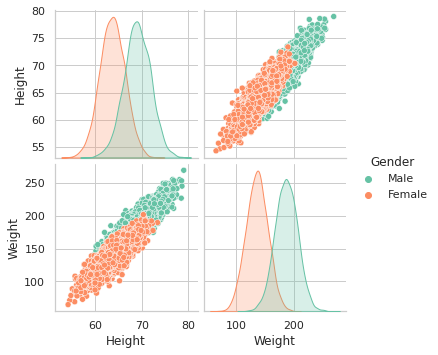

In [14]:
sns.pairplot(dataset, hue="Gender", palette="Set2", diag_kind="kde", height=2.5)

Convert Pandas DataFrame into NumPy Array using 'iloc'.

In [15]:
X_Data = dummy_dataset.iloc[:,0:-1].values # All columns except the last are the predicting variables
Y_Data = dummy_dataset.iloc[:,-1].values # Last column (Weight Column in this case) is the label
print(X_Data.shape)
print(Y_Data.shape)

(10000, 3)
(10000,)


Train-Test Split

In [16]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

The third axis is to show the number of channels, which is 1 in this case. If same labels were appropriate for more than 1 dataset, there would be more than 1 channel.

In [17]:
X_Train = np.expand_dims(X_Train, axis=2)
X_Test = np.expand_dims(X_Test, axis=2)

In [18]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(8000, 3, 1) (2000, 3, 1)
(8000,) (2000,)


### Build and Train Imported Data using the VGG based Regression Model

Configurations

In [19]:
"Configurations for VGG in Regression Mode"
length = X_Train.shape[1]   # Number of Features (or length of the signal)
model_width = 128           # Number of Filter or Kernel in the Input Layer
num_channel = 1             # Number of Input Channels
problem_type = 'Regression' # Regression or Classification
output_number = 1           # Number of Outputs in the Regression Mode

Build Model

In [21]:
Regression_Model = VGG(length, num_channel, model_width, problem_type=problem_type, output_nums=output_number).VGG19() # Build Model
# VGG Models supported: VGG11, VGG16, VGG16_v2. VGG19
Regression_Model.compile(loss='mae', optimizer='adam', metrics= ['mse']) # Compile Model
# Here, Model validation metric is set as Mean Squared Error or MSE

Model_Summary

In [23]:
Regression_Model.summary() # Summary of the Model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 128)            512       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 128)            512       
_________________________________________________________________
activation (Activation)      (None, 3, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 128)            49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 128)            512       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 128)            0     

Upload Past Weights if available (Transfer Learning)

In [ ]:
Regression_Model.load_weights('Saved_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model for 'n' number of Epochs with Batch size of 'm'

In [24]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min'), ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Regression_Model.fit(X_Train, Y_Train, epochs=500, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)
# Save 'History' of the model for model performance analysis performed later

Epoch 1/500
50/50 [==============================] - 37s 68ms/step - loss: 56.1027 - mse: 6534.5944 - val_loss: 72.4356 - val_mse: 5673.2363

Epoch 00001: val_loss improved from inf to 72.43564, saving model to Saved_Model.h5
Epoch 2/500
50/50 [==============================] - 2s 38ms/step - loss: 14.8119 - mse: 346.7887 - val_loss: 45.1022 - val_mse: 2545.8071

Epoch 00002: val_loss improved from 72.43564 to 45.10220, saving model to Saved_Model.h5
Epoch 3/500
50/50 [==============================] - 2s 38ms/step - loss: 12.5942 - mse: 250.0669 - val_loss: 20.7407 - val_mse: 611.8153

Epoch 00003: val_loss improved from 45.10220 to 20.74068, saving model to Saved_Model.h5
Epoch 4/500
50/50 [==============================] - 2s 38ms/step - loss: 12.2594 - mse: 243.2860 - val_loss: 36.0082 - val_mse: 1645.8827

Epoch 00004: val_loss did not improve from 20.74068
Epoch 5/500
50/50 [==============================] - 2s 38ms/step - loss: 13.0808 - mse: 265.5669 - val_loss: 29.3202 - val_m

Test and Predict

In [25]:
# Preictions from the Test Set from the Trained Model
Predictions = Regression_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

63/63 [==============================] - 2s 9ms/step
(2000, 1)


Error Performance (Mean Sqaured Error or MAE)

In [26]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 41.12301291313756


Plot Train and Validation Error and Loss

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


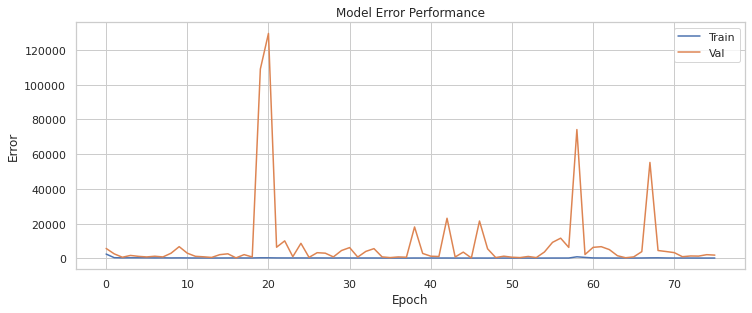

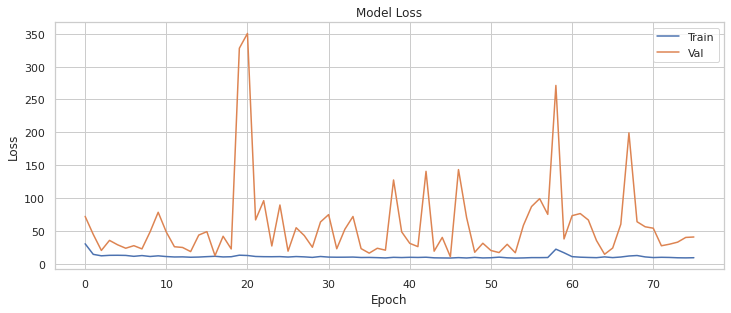

In [27]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Plot Prediction Performance

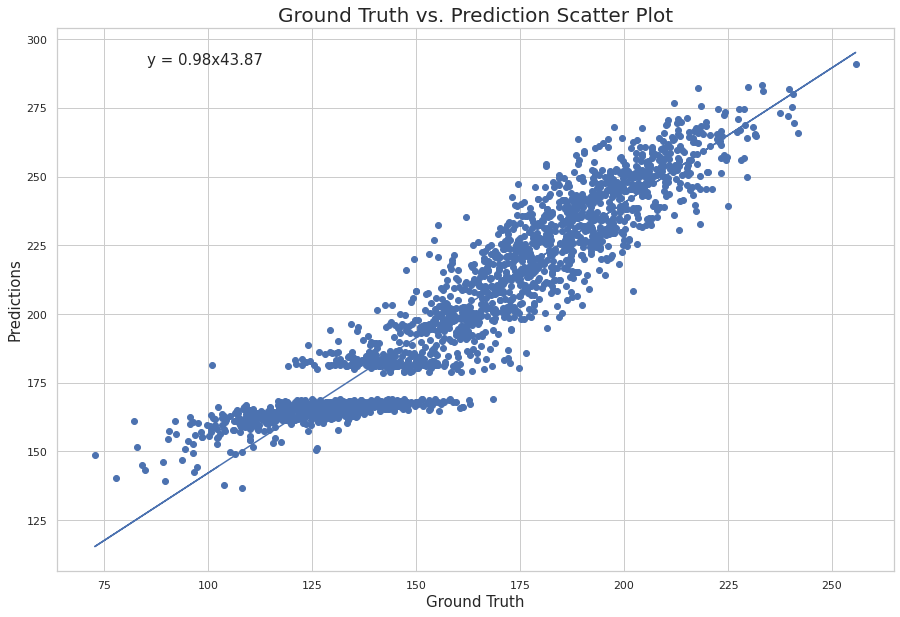

In [28]:
def plot_prediction(test_labels, test_predictions):
  plt.figure(figsize=(15,10))
  plt.scatter(test_labels, test_predictions)
  '''Add Trendline'''
  z = np.polyfit(test_labels.ravel(), test_predictions.ravel(), 1)
  p = np.poly1d(z)
  plt.plot(test_labels, p(test_labels))
  plt.text(np.max(test_labels)/3,np.max(test_predictions),f'y = {p[1]:.2f}x{p[0]:.2f}', fontsize=15)
  plt.title('Ground Truth vs. Prediction Scatter Plot', fontsize=20)
  plt.xlabel('Ground Truth', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
#
plot_prediction(Y_Test, Predictions)

Kernel Density Plot

Text(0, 0.5, 'Density')

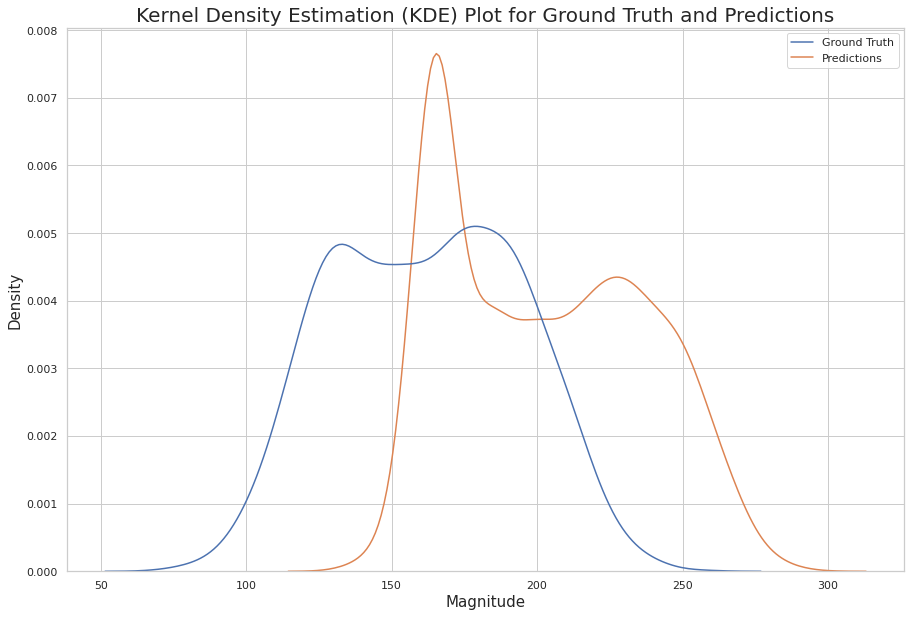

In [29]:
df = pd.DataFrame(data = {'Ground Truth': Y_Test.ravel(), 'Predictions': Predictions.ravel()})
plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.kdeplot(data=df)
plt.title('Kernel Density Estimation (KDE) Plot for Ground Truth and Predictions', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)

Text(0, 0.5, 'Magnitude')

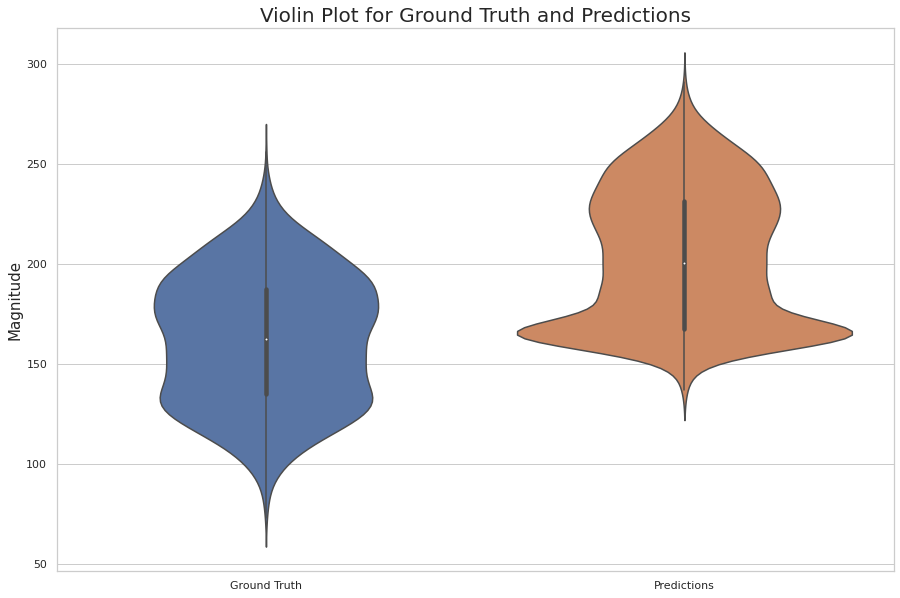

In [30]:
plt.figure(figsize = (15,10))
df = pd.DataFrame(data = {'Ground Truth': Y_Test.ravel(), 'Predictions': Predictions.ravel()})
ax = sns.violinplot(data=df)
plt.title('Violin Plot for Ground Truth and Predictions', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)

## Classification

### Data Preparation

Import the dataset from a CSV file and save it into a Pandas DataFrame

In [31]:
dataset = pd.read_excel('Drug_Persistency.xlsx', sheet_name = 'Dataset')
dataset.drop(columns=['Ptid'], inplace=True) # Drop Patient ID Column
print(dataset.shape)
dataset.head(10)

(3424, 68)


,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,N,N,N,N,N,N,N,2
6,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,2,Y,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,N,N,Y,Y,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N,Y,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1
7,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/

Create a Blank DataFrame

In [32]:
dummy_dataset = pd.DataFrame()

In [33]:
for i in range(0,len(dataset.columns)):
  X = dataset[dataset.columns[i]]
  if type(X[0]) == str:
    Y = pd.get_dummies(X)
    dummy_dataset = pd.concat([dummy_dataset, Y], axis=1)
  else:
    dummy_dataset = pd.concat([dummy_dataset, X], axis=1)
#
dummy_dataset.head(10)

,Non-Persistent,Persistent,Female,Male,African American,Asian,Caucasian,Other/Unknown,Hispanic,Not Hispanic,Unknown,Midwest,Northeast,Other/Unknown,South,West,55-65,65-75,<55,>75,CARDIOLOGY,CLINICAL NURSE SPECIALIST,EMERGENCY MEDICINE,ENDOCRINOLOGY,GASTROENTEROLOGY,GENERAL PRACTITIONER,GERIATRIC MEDICINE,HEMATOLOGY & ONCOLOGY,HOSPICE AND PALLIATIVE MEDICINE,HOSPITAL MEDICINE,NEPHROLOGY,NEUROLOGY,NUCLEAR MEDICINE,OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY,OBSTETRICS AND GYNECOLOGY,OCCUPATIONAL MEDICINE,ONCOLOGY,OPHTHALMOLOGY,ORTHOPEDIC SURGERY,ORTHOPEDICS,...,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,N,Y,Count_Of_Risks
0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
2,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
3,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
5,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2
6,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
7,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
8,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
9,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1


Convert the DataFrame to a Numpy Array

In [34]:
X_Data = dummy_dataset.iloc[:,0:-1].values
Y_Data = dummy_dataset.iloc[:,-1].values
print(X_Data.shape)
print(Y_Data.shape)

(3424, 182)
(3424,)


Get Unique Labels

In [35]:
'''Print out the Classes to track the sequence, will be important in the evaluation section (e.g., Labelling Conf Mat)'''
L_E = LabelEncoder()
L_E.fit_transform(Y_Data)
labels = L_E.classes_
print(f'Classes: {labels}')

Classes: [0 1 2 3 4 5 6 7]


Train_Test Split

In [36]:
X_Train, X_Test, Y_Train_, Y_Test_ = train_test_split(X_Data, Y_Data, test_size=0.20, random_state=42)

One-Hot-Encoding for the Classification Labels

In [37]:
def one_hot_encoding(data):
  L_E = LabelEncoder()
  integer_encoded = L_E.fit_transform(data)  
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  one_hot_encoded_data = onehot_encoder.fit_transform(integer_encoded)
  return one_hot_encoded_data

In [38]:
Y_Train = one_hot_encoding(Y_Train_.ravel())
Y_Test = one_hot_encoding(Y_Test_.ravel())

Train and Test Data Shapes

In [39]:
print(X_Train.shape, X_Test.shape)
print(Y_Train.shape, Y_Test.shape)

(2739, 182) (685, 182)
(2739, 8) (685, 8)


### Build and Train Imported Data using the VGG based Classification Model

Configurations

In [40]:
"Configurations for the 1D Network in Classification Mode"
length = X_Train.shape[1]       # Number of Features (or length of the signal)
model_width = 32                # Number of Filter or Kernels in the Input Layer
num_channel = 1                 # Number of Input Channels
problem_type = 'Classification' # Regression or Classification
class_number = Y_Train.shape[1] # Number of Output Class in Classification Mode (>=2)

Build Model

In [41]:
Classification_Model = VGG(length, num_channel, model_width, problem_type=problem_type, output_nums=class_number).VGG19() # Change the VGG Model if needed
if class_number == 2:
  Classification_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse','accuracy'])
elif class_number > 2:
  Classification_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse','accuracy'])

Model Summary

In [42]:
Classification_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 182, 1)]          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 182, 32)           128       
_________________________________________________________________
batch_normalization_16 (Batc (None, 182, 32)           128       
_________________________________________________________________
activation_16 (Activation)   (None, 182, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 182, 32)           3104      
_________________________________________________________________
batch_normalization_17 (Batc (None, 182, 32)           128       
_________________________________________________________________
activation_17 (Activation)   (None, 182, 32)           0   

Upload Past Weights (Transfer Learning)

In [ ]:
Classification_Model.load_weights('Saved_Model.h5') # Load Previously Trained Weights for Transfer Learning

Train Model

In [43]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [EarlyStopping(monitor='val_loss', patience=50, mode='min'), ModelCheckpoint('Saved_Model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Classification_Model.fit(X_Train, Y_Train, epochs=300, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/300
18/18 [==============================] - 8s 118ms/step - loss: 3.2218 - mse: 0.1127 - accuracy: 0.2571 - val_loss: 1.7169 - val_mse: 0.0984 - val_accuracy: 0.2299

Epoch 00001: val_loss improved from inf to 1.71688, saving model to Saved_Model.h5
Epoch 2/300
18/18 [==============================] - 1s 31ms/step - loss: 1.4686 - mse: 0.0924 - accuracy: 0.3445 - val_loss: 1.4940 - val_mse: 0.0924 - val_accuracy: 0.3850

Epoch 00002: val_loss improved from 1.71688 to 1.49405, saving model to Saved_Model.h5
Epoch 3/300
18/18 [==============================] - 1s 31ms/step - loss: 1.4244 - mse: 0.0914 - accuracy: 0.3304 - val_loss: 1.4797 - val_mse: 0.0925 - val_accuracy: 0.3923

Epoch 00003: val_loss improved from 1.49405 to 1.47966, saving model to Saved_Model.h5
Epoch 4/300
18/18 [==============================] - 1s 31ms/step - loss: 1.4439 - mse: 0.0917 - accuracy: 0.3340 - val_loss: 1.4842 - val_mse: 0.0924 - val_accuracy: 0.3978

Epoch 00004: val_loss did not improve from

Test

In [44]:
# Predictions from the Test Set from the Trained Model
Predictions = Classification_Model.predict(X_Test, verbose=1)
print(Predictions.shape)

22/22 [==============================] - 1s 7ms/step
(685, 8)


Error Performance

In [45]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(Y_Test, Predictions)
print(f"MAE: {Error}")

MAE: 0.004193527633843704


Plot Training History [Metrics] - Requires to Train the Model

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


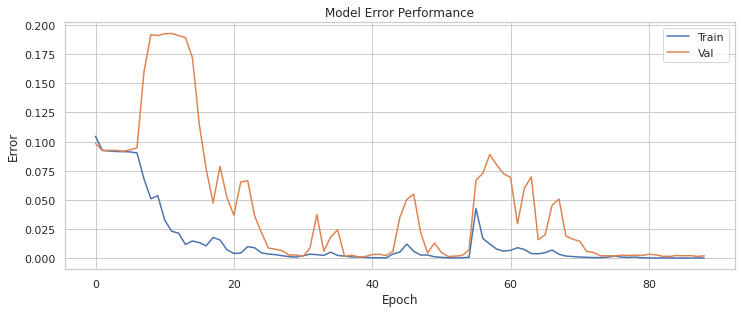

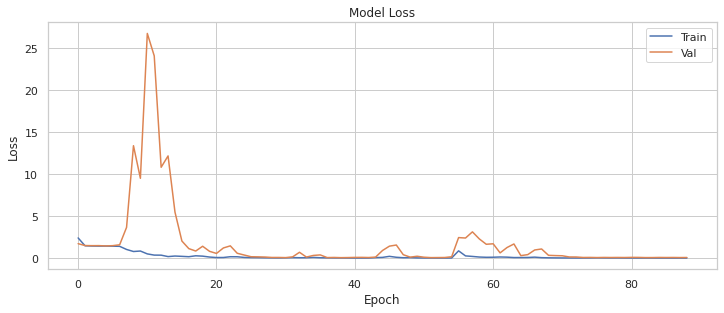

In [46]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Convert raw predictions into single-column, integer-based predictions

In [47]:
prediction_shape = Predictions.shape
prediction_length = prediction_shape[0]
Y_Preds = np.zeros((prediction_length, 1), dtype=int)
#
for i in range(0, prediction_length):
  prediction = Predictions[i]
  x = np.where(prediction == np.max(prediction))
  x = int(x[0])
  Y_Preds[i] = x

Y_Preds.shape

(685, 1)

Print Confusion Matrix

In [48]:
print('-------------------------------------------')
print('Raw Confusion Matrix')
print(confusion_matrix(Y_Test_, Y_Preds, normalize=None))
print('-------------------------------------------')
print('Normalized Confusion Matrix')
print(confusion_matrix(Y_Test_, Y_Preds, normalize='true'))
print('-------------------------------------------')

-------------------------------------------
Raw Confusion Matrix
[[206   0   0   0   0   0   0   0]
 [  0 229   0   0   0   0   0   0]
 [  0   0 154   0   0   0   0   0]
 [  0   0   1  61   0   0   0   0]
 [  0   0   0   5  22   1   0   0]
 [  0   0   0   0   2   1   0   0]
 [  0   0   0   0   1   0   1   0]
 [  0   0   0   0   0   1   0   0]]
-------------------------------------------
Normalized Confusion Matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.01612903 0.98387097 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.17857143 0.78571429 0.03571429
  0.         0.        ]
 [0.         0.         0.         0.         0.66666667 0.33333333
  0.         0.        ]
 [0.         0.         0.         0.         0.5       

Plot Confusion Matrix

In [49]:
# Use the numeric labels or replace with real-class names. But be careful about their respective sequence
labels = ['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7']

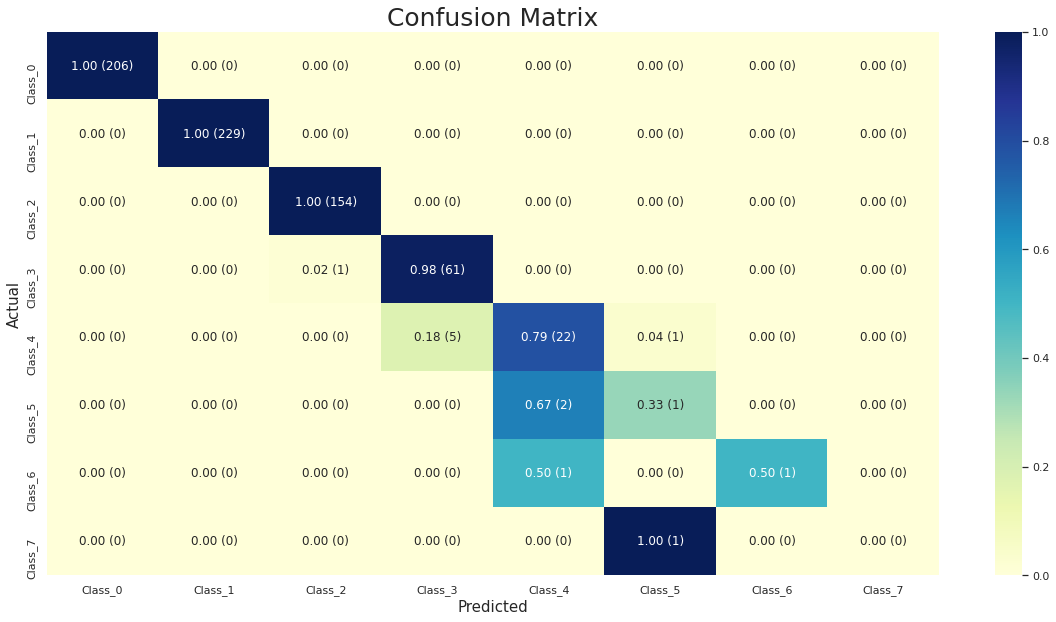

In [50]:
def plot_conf_mat(Ground_Truth_Labels, Predictions):
  confusion_matrix_raw = confusion_matrix(Ground_Truth_Labels, Predictions, normalize=None)
  confusion_matrix_norm = confusion_matrix(Ground_Truth_Labels, Predictions, normalize='true')
  shape = confusion_matrix_raw.shape
  data = np.asarray(confusion_matrix_raw, dtype=int)
  text = np.asarray(confusion_matrix_norm, dtype=float)
  annots = (np.asarray(["{0:.2f} ({1:.0f})".format(text, data) for text, data in zip(text.flatten(), data.flatten())])).reshape(shape[0],shape[1])
  fig = plt.figure(figsize=(20, 10))
  sns.heatmap(confusion_matrix_norm, cmap='YlGnBu', annot=annots, fmt='', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix', fontsize=25)
  plt.xlabel("Predicted", fontsize=15)
  plt.ylabel("Actual", fontsize=15)
#
plot_conf_mat(Y_Test_, Y_Preds)

Here it can be seen that risk level 6 and 7 could not be predicted well due to less number of instances.

In [51]:
# Evaluating Overall Metrics - Accuracy, Precision, Recall, f1-Score
Accuracy = accuracy_score(Y_Test_, Y_Preds)
Precision = precision_score(Y_Test_, Y_Preds, average= 'weighted')
Recall = recall_score(Y_Test_, Y_Preds, average= 'weighted')
f1_Score = f1_score(Y_Test_, Y_Preds, average= 'weighted')
print(f'Accuracy = {Accuracy:.3f}')
print(f'Precision = {Precision:.3f}')
print(f'Recall = {Recall:.3f}')
print(f'f1-Score = {f1_Score:.3f}')

Accuracy = 0.984
Precision = 0.982
Recall = 0.984
f1-Score = 0.983


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(classification_report(Y_Test_, Y_Preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

     Class_0       1.00      1.00      1.00       206
     Class_1       1.00      1.00      1.00       229
     Class_2       0.99      1.00      1.00       154
     Class_3       0.92      0.98      0.95        62
     Class_4       0.88      0.79      0.83        28
     Class_5       0.33      0.33      0.33         3
     Class_6       1.00      0.50      0.67         2
     Class_7       0.00      0.00      0.00         1

    accuracy                           0.98       685
   macro avg       0.77      0.70      0.72       685
weighted avg       0.98      0.98      0.98       685



Multiclass Receiver Operating Characteristic(ROC) Curves Plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


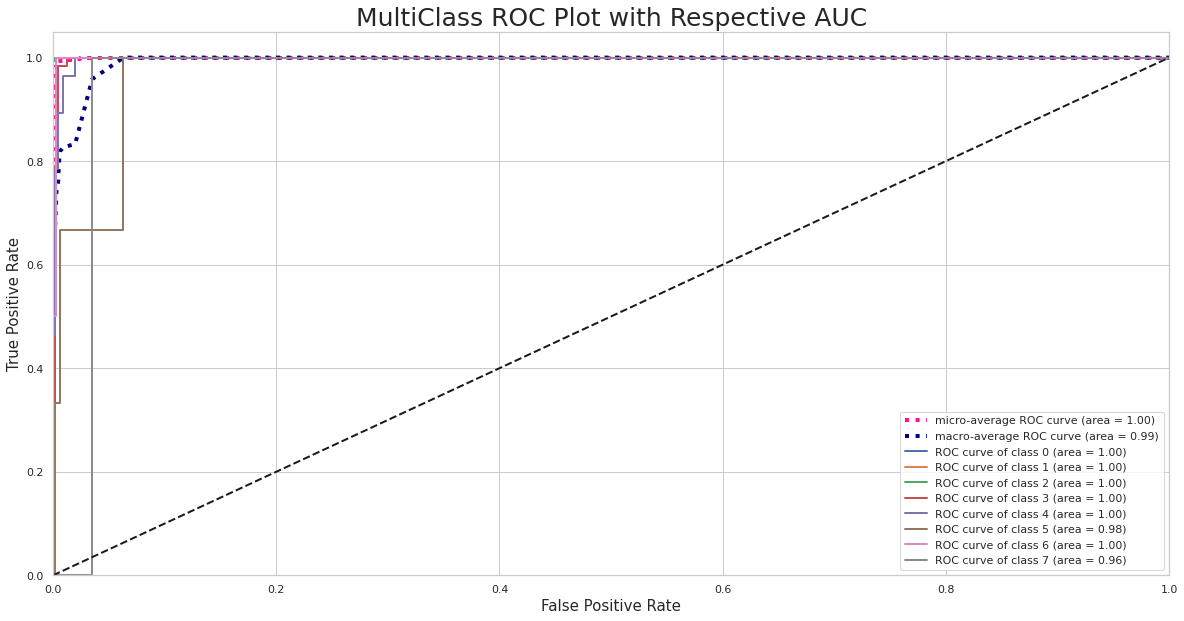

In [53]:
def plot_multiclass_roc(Y_Test, Predictions):
  # Compute ROC curve and Area Under Curve (AUC) for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(class_number):
      fpr[i], tpr[i], _ = roc_curve(Y_Test[:, i], Predictions[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(Y_Test.ravel(), Predictions.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_number)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(class_number):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= class_number

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(20, 10))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  for i in range(class_number):
      plt.plot(fpr[i], tpr[i], lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=15)
  plt.ylabel('True Positive Rate', fontsize=15)
  plt.title('MultiClass ROC Plot with Respective AUC', fontsize=25)
  plt.legend(loc="lower right")
  plt.show()
#
plot_multiclass_roc(Y_Test, Predictions)

Average precision score, micro-averaged over all classes: 1.00


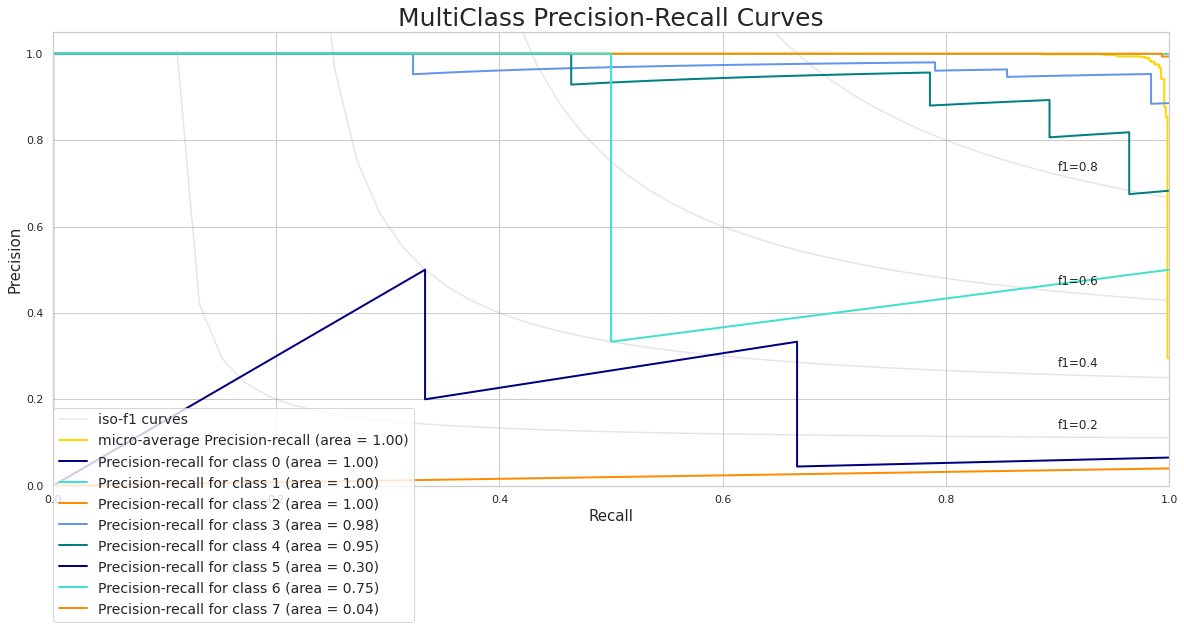

In [54]:
def plot_multiclass_precision_recall_curves(Y_Test, Predictions):
  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(class_number):
      precision[i], recall[i], _ = precision_recall_curve(Y_Test[:, i], Predictions[:, i])
      average_precision[i] = average_precision_score(Y_Test[:, i], Predictions[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(Y_Test.ravel(), Predictions.ravel())
  average_precision["micro"] = average_precision_score(Y_Test, Predictions, average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

  from itertools import cycle
  # setup plot details
  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

  plt.figure(figsize=(20, 10))
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines = []
  labels = []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
      plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

  lines.append(l)
  labels.append('iso-f1 curves')
  l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
  lines.append(l)
  labels.append('micro-average Precision-recall (area = {0:0.2f})'''.format(average_precision["micro"]))

  for i, color in zip(range(class_number), colors):
      l, = plt.plot(recall[i], precision[i], color=color, lw=2)
      lines.append(l)
      labels.append('Precision-recall for class {0} (area = {1:0.2f})'''.format(i, average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall', fontsize=15)
  plt.ylabel('Precision', fontsize=15)
  plt.title('MultiClass Precision-Recall Curves', fontsize=25)
  plt.legend(lines, labels, loc=(0, -.3), prop=dict(size=14))
  plt.show()
#
plot_multiclass_precision_recall_curves(Y_Test, Predictions)